# Final Project 3

Nama            : Farah Alysa Putri <br>
Program         : Introduction to Python for Data Science <br>
Kode Peserta    : PYTN-KS02-001

Anggota Kelompok:
1. Anindita Khusnul Oktavia (PYTN-KS02-006)
2. Farah Alysa Putri        (PYTN-KS02-001)

## Perkenalan

Final Project 3 dibuat guna mengevaluasi konsep Ensemble sebagai berikut:
- Mampu memahami konsep Classification dengan Ensemble Model
- Mampu mempersiapkan data untuk digunakan dalam Ensemble Model
- Mampu mengimplementasikan Ensemble Model untuk membuat prediksi 

Dataset yang digunakan adalah dataset Heart Failure Prediction. Dataset ini memiliki 13 kolom yang diperoleh dari Kaggle pada link https://www.kaggle.com/andrewmvd/heart-failure-clinical-data. Dataset tersebut dapat memprediksi kelangsungan hidup pasien dengan gagal jantung dari serum creatinine dan ejection fraction saja. 

## Import Libraries

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import StandardScaler

In [90]:
# data splitting
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [91]:
# data modeling
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,roc_auc_score,classification_report,f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [92]:
# ensembling
from mlxtend.classifier import StackingCVClassifier
import xgboost as xgb
import itertools
from sklearn.dummy import DummyClassifier
from sklearn import metrics

## Data Loading

In [93]:
# data loading
data = pd.read_csv('heart_failure_clinical_records_dataset.csv')
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


Dataset terdiri dari 23 atribut, antara lain:
1. age - umur pasien
2. anaemia - apakah ada pengurangan haemoglobin
3. creatinine_phosphokinase - level enzim CPK dalam mcg/L
4. diabetes - apakah pasien punya riwayat diabetes
5. ejection_fraction - persentase darah yang meninggalkan jantung dalam persentasi di setiap kontraksi jantung
6. high_blood_pressure - apakah pasien punya darah tinggi
7. platelets - jumlah platelet di darah dalam kiloplatelets/mL
8. serum_creatinine - level serum creatinine di darah dalam mg/dL
9. serum_sodium - level serum sodium di darah dalam mEq/L
10. sex - apakah pasien pria atau wanita
11. smoking - apakah pasien merokok
12. time - waktu dalam hari untuk follow-up
13. DEATH_EVENT - apakah pasien sudah meninggal saat waktu follow-up

In [94]:
data.shape

(299, 13)

Dataset terdiri dari 299 baris dan 13 kolom

In [95]:
# cek type data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


## Exploratory Data Analysis

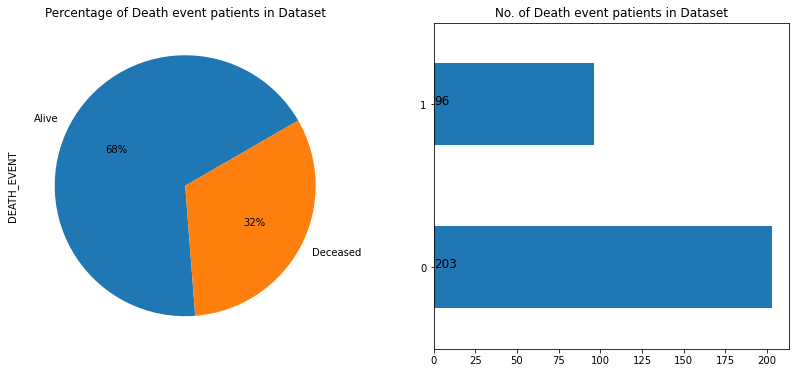

In [96]:
# plotting
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(14,6))

ax1 = data['DEATH_EVENT'].value_counts().plot.pie( x="Death event" ,y ='no.of patients', 
                   autopct = "%1.0f%%",labels=["Alive","Deceased"], startangle = 30,ax=ax1);
ax1.set(title = 'Percentage of Death event patients in Dataset')

ax2 = data["DEATH_EVENT"].value_counts().plot(kind="barh" ,ax =ax2)
for i,j in enumerate(data["DEATH_EVENT"].value_counts().values):
    ax2.text(.5,i,j,fontsize=12)
ax2.set(title = 'No. of Death event patients in Dataset')
plt.show()

Berdasarkan grafik diatas, dapat dilihat bahwa jumlah pasien yang masih hidup pada waktu follow-up lebih banyak jika dibandingkan dengan pasien yang meninggal. Sebanyak 203 pasien atau 68% pasien hidup, sedangkan 32% sisanya dinyatakan meninggal pada waktu follow-up.

<AxesSubplot:>

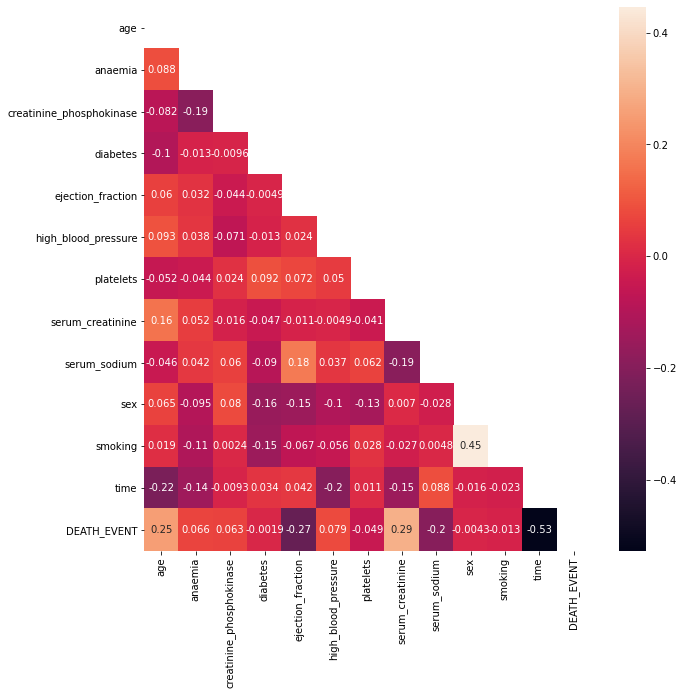

In [97]:
# plot heatmap untuk melihat korelasi antar variabel
plt.figure(figsize=(10,10))
sns.heatmap(data.corr(),annot=True, mask=np.triu(data.corr()))

Berdasarkan heatmap, terjadi korelasi positif antara variabel smoking dan sex. Sedangkan korelasi negatif terjadi antara variabel death event dan time.

## Preprocessing

In [98]:
# split data train dan test
X = data.drop(['DEATH_EVENT'],axis=1)
y = data['DEATH_EVENT']

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 0)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [100]:
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)
DummyClassifier(strategy='stratified')
dummy_clf.predict(X_test)
dummy_clf.score(X_test, y_test)

0.5666666666666667

## Modelling

### Logistic Regression

In [101]:
# LOGISTIC REGRESSION
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
# prediction
y_pred_log = logreg.predict(X_test)
lr_acc_score=metrics.accuracy_score(y_test, y_pred_log)
lr_f1_score=metrics.f1_score(y_test, y_pred_log)

In [102]:
# checking accuracy
print('Test Accuracy score: ', lr_acc_score)
print('Test F1 score: ', lr_f1_score)
print("\n")
print(classification_report(y_test,y_pred_log))

Test Accuracy score:  0.7833333333333333
Test F1 score:  0.6285714285714286


              precision    recall  f1-score   support

           0       0.75      0.97      0.85        37
           1       0.92      0.48      0.63        23

    accuracy                           0.78        60
   macro avg       0.83      0.73      0.74        60
weighted avg       0.81      0.78      0.76        60



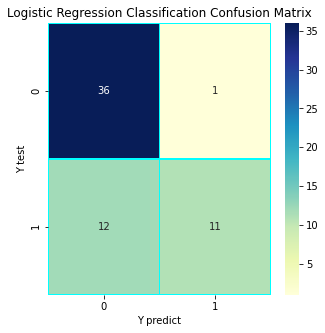

In [103]:
# confusion matrix
logreg_cm = confusion_matrix(y_test,y_pred_log)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(logreg_cm, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="YlGnBu")
plt.title('Logistic Regression Classification Confusion Matrix')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()

Berdasarkan Logistic Regression Confusion Matrix, diperoleh hasil sebagai berikut:
1. “True Positive” - Frekuensi prediksi bahwa pasien hidup (0) dan sesuai dengan data aktual bahwa pasien hidup (0) sebanyak 36.
2. “False Positive” - Frekuensi prediksi bahwa pasien hidup (0), namun pada data aktual menunjukkan bahwa pasien meninggal (1) sebanyak 1.
3. “False Negative” - Frekuensi prediksi bahwa pasien meninggal (1), namun pada data aktual menunjukkan bahwa pasien hidup (0) sebanyak 12.
4. "True Positive" - Frekuensi prediksi bahwa pasien meninggal (1) dan sesuai dengan data aktual bahwa pasien meninggal (1) sebanyak 11.

### K-Nearest Neighbor

In [104]:
# KNN MODEL
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
# prediction
y_pred_knn = knn.predict(X_test)
knn_acc_score=metrics.accuracy_score(y_test, y_pred_knn)
knn_f1_score=metrics.f1_score(y_test, y_pred_knn)

In [105]:
# checking accuracy
print('Test Accuracy score: ', knn_acc_score)
print('Test F1 score: ',knn_f1_score )
print("\n")
print(classification_report(y_test,y_pred_knn))

Test Accuracy score:  0.7166666666666667
Test F1 score:  0.48484848484848486


              precision    recall  f1-score   support

           0       0.70      0.95      0.80        37
           1       0.80      0.35      0.48        23

    accuracy                           0.72        60
   macro avg       0.75      0.65      0.64        60
weighted avg       0.74      0.72      0.68        60



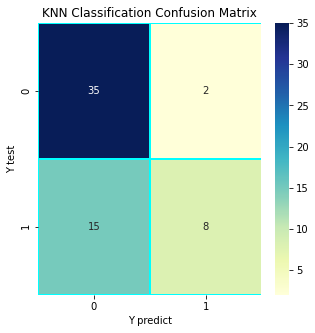

In [106]:
# confusion matrix
knncla_cm = confusion_matrix(y_test,y_pred_knn)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(knncla_cm, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="YlGnBu")
plt.title('KNN Classification Confusion Matrix')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()

Berdasarkan KNN Confusion Matrix, diperoleh hasil sebagai berikut:
1. “True Positive” - Frekuensi prediksi bahwa pasien hidup (0) dan sesuai dengan data aktual bahwa pasien hidup (0) sebanyak 35.
2. “False Positive” - Frekuensi prediksi bahwa pasien hidup (0), namun pada data aktual menunjukkan bahwa pasien meninggal (1) sebanyak 2.
3. “False Negative” - Frekuensi prediksi bahwa pasien meninggal (1), namun pada data aktual menunjukkan bahwa pasien hidup (0) sebanyak 15.
4. "True Positive" - Frekuensi prediksi bahwa pasien meninggal (1) dan sesuai dengan data aktual bahwa pasien meninggal (1) sebanyak 8.

### Support Vector Classifier

In [107]:
# SVC
svc =  SVC(kernel='rbf', C=2)
svc.fit(X_train, y_train)
# prediction
y_pred_svc = svc.predict(X_test)
svc_acc_score = metrics.accuracy_score(y_test, y_pred_svc)
svc_f1_score = metrics.f1_score(y_test, y_pred_svc)

In [108]:
# checking accuracy
print('Test Accuracy score: ',svc_acc_score)
print('Test F1 score: ', svc_f1_score)
print("\n")
print("Accuracy of Support Vector Classifier:",svc_acc_score,'\n')
print(classification_report(y_test,y_pred_svc))

Test Accuracy score:  0.8
Test F1 score:  0.6842105263157895


Accuracy of Support Vector Classifier: 0.8 

              precision    recall  f1-score   support

           0       0.78      0.95      0.85        37
           1       0.87      0.57      0.68        23

    accuracy                           0.80        60
   macro avg       0.82      0.76      0.77        60
weighted avg       0.81      0.80      0.79        60



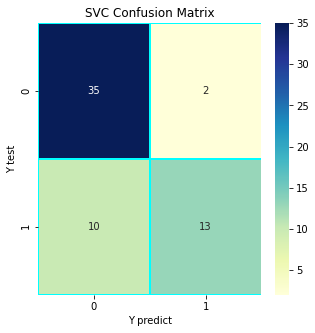

In [109]:
# confusion matrix
svmcla_cm = confusion_matrix(y_test,y_pred_svc)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(svmcla_cm, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="YlGnBu")
plt.title('SVC Confusion Matrix')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()

Berdasarkan SVC Confusion Matrix, diperoleh hasil sebagai berikut:
1. “True Positive” - Frekuensi prediksi bahwa pasien hidup (0) dan sesuai dengan data aktual bahwa pasien hidup (0) sebanyak 35.
2. “False Positive” - Frekuensi prediksi bahwa pasien hidup (0), namun pada data aktual menunjukkan bahwa pasien meninggal (1) sebanyak 2.
3. “False Negative” - Frekuensi prediksi bahwa pasien meninggal (1), namun pada data aktual menunjukkan bahwa pasien hidup (0) sebanyak 10.
4. "True Positive" - Frekuensi prediksi bahwa pasien meninggal (1) dan sesuai dengan data aktual bahwa pasien meninggal (1) sebanyak 13.

### Decision Tree

In [110]:
# DECISION TREE MODEL
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
# prediction
y_pred_tree = tree.predict(X_test)
tree_acc_score=metrics.accuracy_score(y_test, y_pred_tree)
tree_f1_score=metrics.f1_score(y_test, y_pred_tree)

In [111]:
# checking accuracy
print('Test Accuracy score: ', tree_acc_score)
print('Test F1 score: ', tree_f1_score)
print("\n")
print(classification_report(y_test,y_pred_tree))

Test Accuracy score:  0.75
Test F1 score:  0.6341463414634146


              precision    recall  f1-score   support

           0       0.76      0.86      0.81        37
           1       0.72      0.57      0.63        23

    accuracy                           0.75        60
   macro avg       0.74      0.72      0.72        60
weighted avg       0.75      0.75      0.74        60



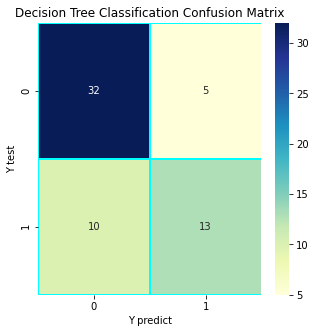

In [112]:
# confusion matrix
dtcla_cm = confusion_matrix(y_test,y_pred_tree)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(dtcla_cm, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="YlGnBu")
plt.title('Decision Tree Classification Confusion Matrix')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()

Berdasarkan Decision Tree Confusion Matrix, diperoleh hasil sebagai berikut:
1. “True Positive” - Frekuensi prediksi bahwa pasien hidup (0) dan sesuai dengan data aktual bahwa pasien hidup (0) sebanyak 32.
2. “False Positive” - Frekuensi prediksi bahwa pasien hidup (0), namun pada data aktual menunjukkan bahwa pasien meninggal (1) sebanyak 5.
3. “False Negative” - Frekuensi prediksi bahwa pasien meninggal (1), namun pada data aktual menunjukkan bahwa pasien hidup (0) sebanyak 10.
4. "True Positive" - Frekuensi prediksi bahwa pasien meninggal (1) dan sesuai dengan data aktual bahwa pasien meninggal (1) sebanyak 13.

### Random Forest

In [113]:
# RANDOM FOREST MODEL
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
# prediction
y_pred_forest = rfc.predict(X_test)
rfc_acc_score=metrics.accuracy_score(y_test, y_pred_forest)
rfc_f1_score = metrics.f1_score(y_test, y_pred_forest)

In [114]:
# checking accuracy
print('Test Accuracy score: ', rfc_acc_score)
print('Test F1 score: ', rfc_f1_score)
print("\n")
print(classification_report(y_test,y_pred_forest))

Test Accuracy score:  0.8166666666666667
Test F1 score:  0.717948717948718


              precision    recall  f1-score   support

           0       0.80      0.95      0.86        37
           1       0.88      0.61      0.72        23

    accuracy                           0.82        60
   macro avg       0.84      0.78      0.79        60
weighted avg       0.83      0.82      0.81        60



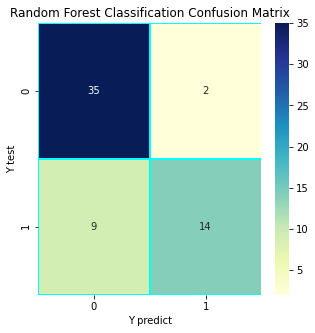

In [115]:
# confusion matrix
rfcla_cm = confusion_matrix(y_test,y_pred_forest)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(rfcla_cm, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="YlGnBu")
plt.title('Random Forest Classification Confusion Matrix')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()

Berdasarkan Random Forest Confusion Matrix, diperoleh hasil sebagai berikut:
1. “True Positive” - Frekuensi prediksi bahwa pasien hidup (0) dan sesuai dengan data aktual bahwa pasien hidup (0) sebanyak 36.
2. “False Positive” - Frekuensi prediksi bahwa pasien hidup (0), namun pada data aktual menunjukkan bahwa pasien meninggal (1) sebanyak 1.
3. “False Negative” - Frekuensi prediksi bahwa pasien meninggal (1), namun pada data aktual menunjukkan bahwa pasien hidup (0) sebanyak 8.
4. "True Positive" - Frekuensi prediksi bahwa pasien meninggal (1) dan sesuai dengan data aktual bahwa pasien meninggal (1) sebanyak 15.

### Naive Bayes

In [116]:
# Naive Bayes
nb = GaussianNB()
nb.fit(X_train,y_train)
# prediction
y_pred_nb = nb.predict(X_test)
nb_acc_score = metrics.accuracy_score(y_test, y_pred_nb)
nb_f1_score=metrics.f1_score(y_test, y_pred_nb)

In [117]:
# checking accuracy
print('Test Accuracy score: ',nb_acc_score)
print('Test F1 score: ', nb_f1_score)
print("\n")
print(classification_report(y_test,y_pred_nb))

Test Accuracy score:  0.6833333333333333
Test F1 score:  0.42424242424242425


              precision    recall  f1-score   support

           0       0.68      0.92      0.78        37
           1       0.70      0.30      0.42        23

    accuracy                           0.68        60
   macro avg       0.69      0.61      0.60        60
weighted avg       0.69      0.68      0.64        60



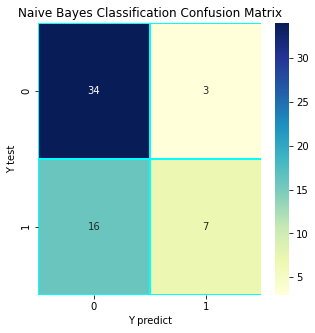

In [118]:
# confusion matrix
rfcla_cm = confusion_matrix(y_test, y_pred_nb)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(rfcla_cm, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="YlGnBu")
plt.title('Naive Bayes Classification Confusion Matrix')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()

Berdasarkan Logistic Regression Confusion Matrix, diperoleh hasil sebagai berikut:
1. “True Positive” - Frekuensi prediksi bahwa pasien hidup (0) dan sesuai dengan data aktual bahwa pasien hidup (0) sebanyak 34.
2. “False Positive” - Frekuensi prediksi bahwa pasien hidup (0), namun pada data aktual menunjukkan bahwa pasien meninggal (1) sebanyak 3.
3. “False Negative” - Frekuensi prediksi bahwa pasien meninggal (1), namun pada data aktual menunjukkan bahwa pasien hidup (0) sebanyak 16.
4. "True Positive" - Frekuensi prediksi bahwa pasien meninggal (1) dan sesuai dengan data aktual bahwa pasien meninggal (1) sebanyak 7.

### XGBClassifier

In [119]:
# XGBClassifier: xg_cl
xg_cl = xgb.XGBClassifier(learning_rate=0.01, n_estimators=10, seed=25)
xg_cl.fit(X_train,y_train)
# prediction
y_pred_xgb = xg_cl.predict(X_test)
xgb_acc_score=metrics.accuracy_score(y_test, y_pred_xgb)
xgb_f1_score = metrics.f1_score(y_test, y_pred_xgb)

[09:56:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Farah\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [120]:
# checking accuracy
print('Test Accuracy score: ',xgb_acc_score)
print('Test F1 score: ', xgb_f1_score)
print("\n")
print(classification_report(y_test,y_pred_xgb))

Test Accuracy score:  0.8
Test F1 score:  0.7142857142857143


              precision    recall  f1-score   support

           0       0.80      0.89      0.85        37
           1       0.79      0.65      0.71        23

    accuracy                           0.80        60
   macro avg       0.80      0.77      0.78        60
weighted avg       0.80      0.80      0.80        60



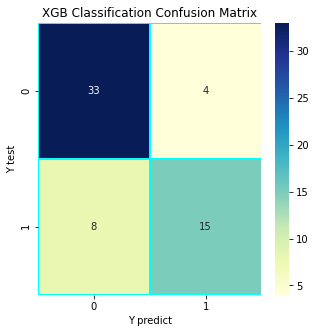

In [121]:
# confusion matrix
rfcla_cm = confusion_matrix(y_test,y_pred_xgb)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(rfcla_cm, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="YlGnBu")
plt.title('XGB Classification Confusion Matrix')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()

Berdasarkan XGB Confusion Matrix, diperoleh hasil sebagai berikut:
1. “True Positive” - Frekuensi prediksi bahwa pasien hidup (0) dan sesuai dengan data aktual bahwa pasien hidup (0) sebanyak 33.
2. “False Positive” - Frekuensi prediksi bahwa pasien hidup (0), namun pada data aktual menunjukkan bahwa pasien meninggal (1) sebanyak 4.
3. “False Negative” - Frekuensi prediksi bahwa pasien meninggal (1), namun pada data aktual menunjukkan bahwa pasien hidup (0) sebanyak 8.
4. "True Positive" - Frekuensi prediksi bahwa pasien meninggal (1) dan sesuai dengan data aktual bahwa pasien meninggal (1) sebanyak 15.

## Evaluasi Model

In [122]:
# membandingkan model
model_ev = pd.DataFrame({'Model': ['Logistic Regression','Random Forest','Extreme Gradient Boost',
                    'K-Nearest Neighbour','Decision Tree','Naive Bayes', 'Support Vector Classifier'], 'Accuracy': [lr_acc_score,
                    rfc_acc_score,xgb_acc_score,knn_acc_score,tree_acc_score,nb_acc_score, svc_acc_score]})
model_ev

,Model,Accuracy
0,Logistic Regression,0.783333
1,Random Forest,0.816667
2,Extreme Gradient Boost,0.800000
3,K-Nearest Neighbour,0.716667
4,Decision Tree,0.750000
5,Naive Bayes,0.683333
6,Support Vector Classifier,0.800000


Berdasarkan perbandingan nilai akurasi dari 6 algoritma model machine learning, model dengan nilai akurasi tertinggi adalah model Random Forest dengan nilai akurasi sebesar 0.8. Sehingga algoritma yang paling sesuai untuk digunakan adalah Random Forest.

### Ensemble Machine Learning (Stacking)

Stacking adalah ensemble machine learning algorithm yang mempelajari cara terbaik untuk menggabungkan prediksi dari beberapa model machine learning yang memiliki tingkat akurasi tinggi.<br>
Berdasarkan perbandingan nilai akurasi dari 6 algoritma model machine learning, 3 model dengan nilai akurasi tertinggi adalah model Random Forest, Extreme Gradient Boost, dan Support Vector Classifier. Sehingga dilakukan ensemble machine learning algorithm dari 3 model terbaik tersebut.

In [123]:
# top 3 model: Random Forest, Extreme Gradient Boost, Support Vector Classifier
scv=StackingCVClassifier(classifiers=[rfc,xg_cl,svc],meta_classifier=nb,random_state=22)
scv.fit(X_train,y_train)
scv_predicted = scv.predict(X_test)
scv_acc_score = accuracy_score(y_test, scv_predicted)
scv_f1_score = f1_score(y_test, scv_predicted)
print("\n")
print("Accuracy of StackingCVClassifier:",scv_acc_score*100,'\n')
print(classification_report(y_test,scv_predicted))

C:\Users\Farah\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:56:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:56:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:56:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Accuracy of StackingCVClassifier: 85.0 

              precision    

C:\Users\Farah\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Hasil Stacking 3 model terbaik menunjukkan nilai akurasi sebesar 83.34%

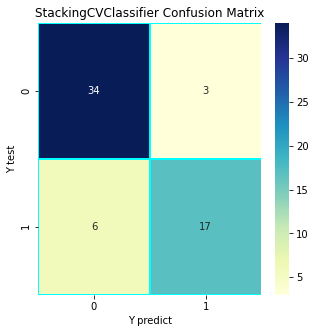

In [124]:
scv_conf_matrix = confusion_matrix(y_test, scv_predicted)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(scv_conf_matrix, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="YlGnBu")
plt.title('StackingCVClassifier Confusion Matrix')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()

Berdasarkan Stacking Confusion Matrix, diperoleh hasil sebagai berikut:
1. “True Positive” - Frekuensi prediksi bahwa pasien hidup (0) dan sesuai dengan data aktual bahwa pasien hidup (0) sebanyak 35.
2. “False Positive” - Frekuensi prediksi bahwa pasien hidup (0), namun pada data aktual menunjukkan bahwa pasien meninggal (1) sebanyak 2.
3. “False Negative” - Frekuensi prediksi bahwa pasien meninggal (1), namun pada data aktual menunjukkan bahwa pasien hidup (0) sebanyak 7.
4. "True Positive" - Frekuensi prediksi bahwa pasien meninggal (1) dan sesuai dengan data aktual bahwa pasien meninggal (1) sebanyak 16.

## Kesimpulan

1. Berdasarkan grafik, jumlah pasien yang masih hidup pada waktu follow-up lebih banyak jika dibandingkan dengan pasien yang meninggal. Sebanyak 203 pasien atau 68% pasien hidup, sedangkan 32% sisanya dinyatakan meninggal pada waktu follow-up.
2. Berdasarkan heatmap, terjadi korelasi positif antara variabel smoking dan sex. Sedangkan korelasi negatif terjadi antara variabel death event dan time.
3. Pada project ini digunakan 7 algoritma model machine learning yang terdiri dari Logistic Regression, Support Vector Machine, Naive Bayes, Decision Tree Score, Random Forest, K-Nearest Neighbour, dan XGBClassifier.
4. Berdasarkan perbandingan nilai akurasi dari 6 algoritma model machine learning, 3 model dengan nilai akurasi tertinggi adalah model Random Forest, Extreme Gradient Boost, dan Support Vector Classifier. Sehingga dilakukan ensemble machine learning algorithm dari 3 model terbaik tersebut. Hasil Stacking 3 model terbaik menunjukkan nilai akurasi sebesar 83.34%.
5. Berdasarkan Stacking Confusion Matrix, diperoleh nilai “True Positive” sebanyak 35, “False Positive” sebanyak 2, “False Negative” sebanyak 7, dan "True Positive" sebanyak 16.